# IAcobus: Neural Networks Tutorial

This notebook shows examples of operation of the custom-written library IAcobus for neural network construction, training, and analysis. The examples have been selected with a reductionist perspective, aiming to convey: i) how to call the library, including how to define the architecture and how configure the traininig parameters; and ii) the underlying rational to tackle different problems, drawing from a mathemetical inspiration. This tutorial does not intent to show good practices or selection of optimal parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from iacobus import IAcobus

## Example 1: one-to-one fit of numerical data

This example shows how to train the neural network to fit a simple function of the form $f(x) = 2x^2$. The training relies on noisy data, and we use the gradient descendent with momentum as minimisation algorithm. After training, $x$ values are forward-propagated to obtain the predictions.

A total of 32 $\times$ ReLU units are used on each hidden layers. The output layer contains a single neuron with linear activation function.

In [2]:
# Generate synthetic data with noise
def scalar_function(x):
    return 2*x**2

n_vals = 100
noise = 10
X_test = np.linspace(-10,10, n_vals).reshape(1, n_vals)
Y_test = scalar_function(X_test) + noise*np.random.randn(1, n_vals)

In [3]:
# Create the network
topology = [32, 32, 1]
activation_funcs = ['relu',
                    'relu',
                    'linear']
n_inputs = 1
ryc = IAcobus(n_inputs,
                topology,
                activation_funcs,
                cost_func='mse')

cost = ryc.train(X_test, Y_test,
                 num_epochs=5000,
                 batch_size=10,
                 learning_rate=1e-5,
                 algorithm='gdm',
                 verbose=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

Cost: 57.78504;   Epoch: 4990/5000: 100%|██████████| 5000/5000 [00:59<00:00, 83.62it/s] 


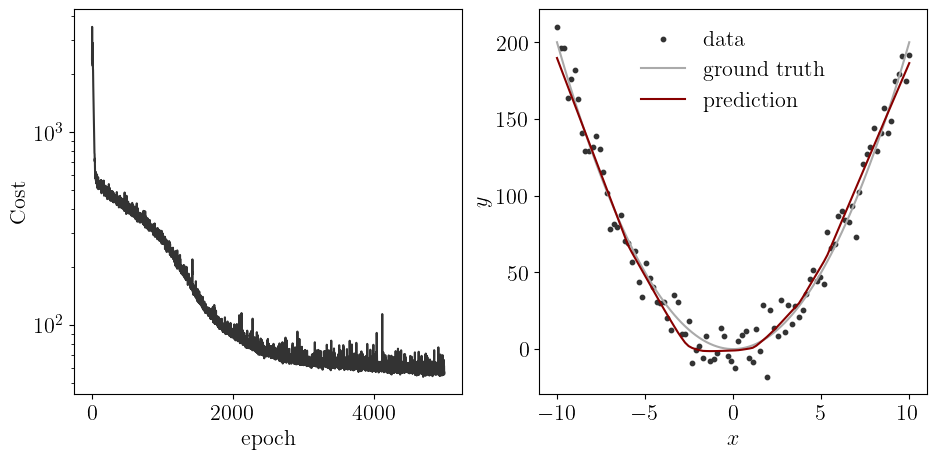

In [4]:
# Plots 
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)

fig, axs = plt.subplots(ncols=2, figsize=(11, 5))
ax_cost = axs[0]
ax_result = axs[1]

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_yscale('log')

ax_result.scatter(X_test.T,
               Y_test.T,
               s=10,
               color="#333333",
               label="data")


ax_result.plot(X_test.T,
               scalar_function(X_test.T),
                color="#aaaaaa",
                label="ground truth")


ax_result.plot(X_test.T,
               ryc.forward(X_test).T,
                color="#880000",
                label="prediction")

ax_result.legend(frameon=False)

ax_result.set_xlabel(r"$x$")
ax_result.set_ylabel(r"$y$")

plt.show()


## Example 2: many-to-one fit of numerical data

We train a neural network to fit a function of the form $z(x,y) = 2x^2+ 3y^2$, which defines a paraboloid. The training relies on noisy data, and after training, pairs of $x,y$ values are forward-propagated to obtain predictions for $z$.

We use 3 hidden layers, where the first two use sigmoids as activation functions. The last layer is a single neuron with linear activation function.

In [5]:
# Generate synthetic data with noise
def scalar_function_two_variables(X,Y):
    return 2*X**2 + 3*Y**2

n_vals = 20
noise = 10
X_test = np.linspace(-10,10, n_vals)
Y_test = np.linspace(-10,10, n_vals)

X_test_grid, Y_test_grid = np.meshgrid(X_test,Y_test)
X_test_grid_flat = X_test_grid.reshape(1, n_vals*n_vals)
Y_test_grid_flat = Y_test_grid.reshape(1, n_vals*n_vals)
XY_test_grid_flat = np.vstack( (X_test_grid_flat.reshape(1, n_vals*n_vals), Y_test_grid_flat.reshape(1, n_vals*n_vals)) )

Z_test = scalar_function_two_variables(X_test_grid_flat, Y_test_grid_flat) + noise*np.random.randn(1, n_vals*n_vals)

In [6]:
# Create the network
topology = [32, 32, 1]
activation_funcs = ['sigmoid',
                    'sigmoid',
                    'linear']
n_inputs = 2
ryc = IAcobus(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='mse')

cost = ryc.train(XY_test_grid_flat,
                 Z_test,
                 num_epochs=500,
                 batch_size=5,
                 learning_rate=1e-2, 
                 verbose=False)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:03<00:00,  7.91it/s]


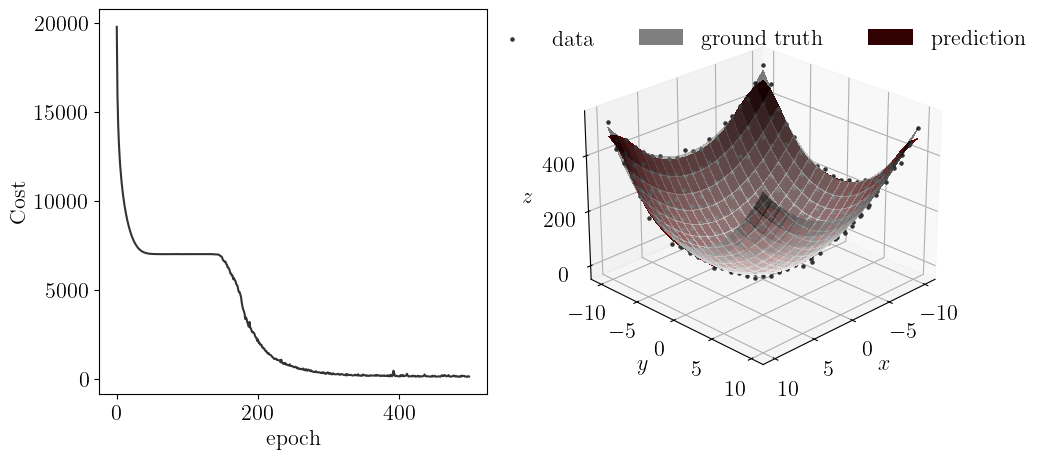

In [7]:
# Plots
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)

fig = plt.figure( figsize=(11, 5) )

# Panel cost
ax_cost = fig.add_subplot(1, 2, 1)
ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")


# Panel 3d fit
ax_result = fig.add_subplot(1, 2, 2, projection='3d')

ax_result.scatter(X_test_grid_flat.T,
                  Y_test_grid_flat.T,
                  Z_test,
                  s=5,
                  color="#333333",
                  depthshade=0,
                  label="data")

surf = ax_result.plot_surface(X_test_grid,
                              Y_test_grid,
                              scalar_function_two_variables(X_test_grid,Y_test_grid),
                              cmap=cm.Greys,
                              alpha=0.5,
                              linewidth=0,
                              antialiased=False,
                              label="ground truth")

ax_result.plot_surface(X_test_grid,
                        Y_test_grid,
                        ryc.forward(XY_test_grid_flat).reshape(n_vals, n_vals),
                        color="#880000",
                        linewidth=0,
                        antialiased=False,
                        label="prediction")

ax_result.view_init(elev=25,
                    azim=45)

ax_result.legend(loc="upper center",
                 ncol=3,
                 frameon=False)

ax_result.set_xlabel(r"$x$")
ax_result.set_ylabel(r"$y$")
ax_result.set_zlabel(r"$z$")

plt.show()


## Example 3: Many-to-many, fitting a vectorial field

We will use the neural network to find an approximate solution to a vectorial field of the form $\mathbb{R}^2 \rightarrow \mathbb{R}^2$. We consider the vectorial field $\mathbf{r}(x,y) = R \sin(-\theta)\mathbf{\hat{i}} + R\cos(\theta) \mathbf{\hat{i}}$, where $\theta \equiv \mathrm{atan}(y/x)$ and $R\equiv \sqrt{x^2 + y^2}$. To make the problem more realistic, the values for the training vectors incoporate random Gaussian noise $\xi = \mathcal{N}(0,1)$ and then $\mathbf{r}_\mathrm{train} = \mathbf{r} + R\xi$ 

In [8]:
# Created the data and prepare it for the traiing 
def vector_field(x, y, noise):

    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(y, x)
    theta = np.where(theta<0, 2*np.pi + theta, theta)
    
    x_true = r*np.sin(-theta)
    y_true = r*np.cos(theta)
    x_comp = x_true + r*noise*np.random.randn(x.shape[0], x.shape[1])
    y_comp = y_true + r*noise*np.random.randn(x.shape[0], x.shape[1])

    return x_comp, y_comp, x_true, y_true

n_vals = 20
noise = 0.20
X_test = np.linspace(-5, 5, n_vals)
Y_test = np.linspace(-5, 5, n_vals)

X_test = X_test.reshape(1,n_vals)
Y_test = Y_test.reshape(1,n_vals)

X_test_grid, Y_test_grid = np.meshgrid(X_test, Y_test)
X_test_grid_flat = X_test_grid.reshape(1, n_vals*n_vals)
Y_test_grid_flat = Y_test_grid.reshape(1, n_vals*n_vals)
XY_test = np.vstack((X_test_grid_flat, Y_test_grid_flat))

u, v, u_true, v_true =  vector_field(X_test_grid_flat, Y_test_grid_flat, noise)
UV_test = np.vstack((u,v))
UV_true = np.vstack((u_true, v_true))

In [9]:
# Create the network
n_inputs = 2
topology = [16, 16, 2]
activation_funcs = ['relu',
                    'relu',
                    'linear']

ryc = IAcobus(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='mse')

cost = ryc.train(XY_test,
                 UV_test,
                 num_epochs = 700,
                 batch_size = 5,
                 learning_rate = 1e-3,
                 algorithm = 'adam',
                 verbose=False)


UV_pred = ryc.forward(XY_test)


100%|██████████| 700/700 [00:53<00:00, 13.18it/s]


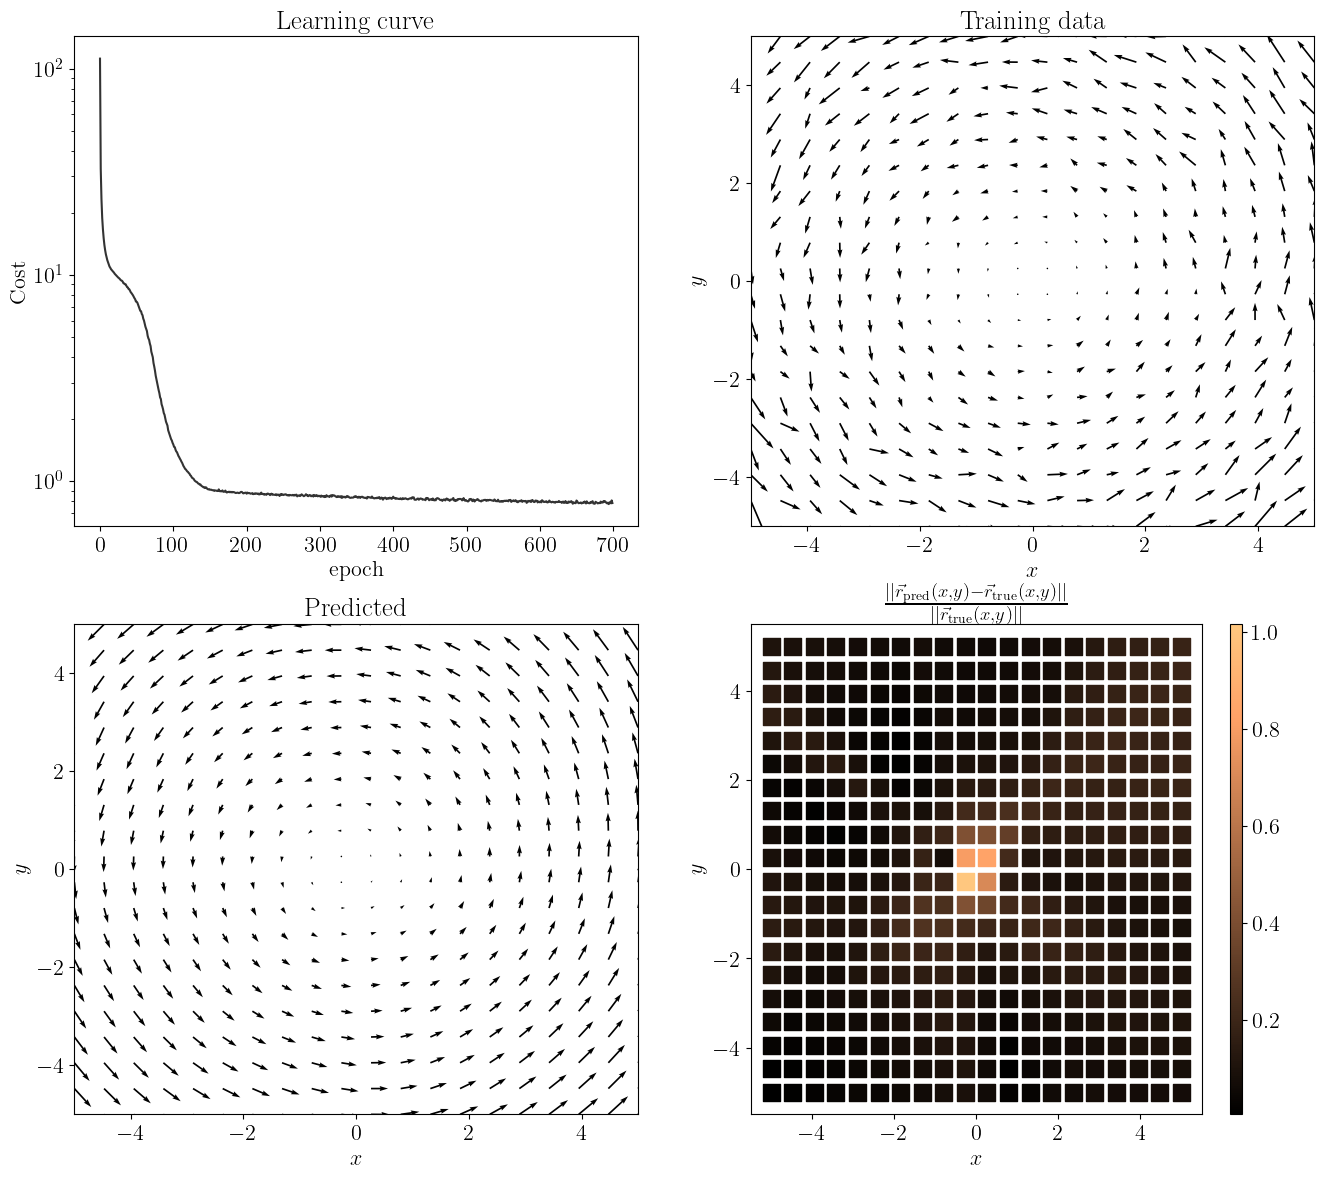

In [10]:
# Plots
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)


fig = plt.figure( figsize=(16, 14) )

#---

ax_cost = fig.add_subplot(2, 2, 1)

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_yscale('log')
ax_cost.set_title("Learning curve")

#---

ax_input = fig.add_subplot(2, 2, 2)
ax_input.quiver(X_test_grid_flat, Y_test_grid_flat, u, v)

ax_input.set_ylabel(r"$y$")
ax_input.set_xlabel(r"$x$")
ax_input.set_ylim([-5, 5])
ax_input.set_xlim([-5, 5])
ax_input.set_title("Training data")

#---
ax_predicted = fig.add_subplot(2, 2, 3)
ax_predicted.quiver(X_test_grid_flat, Y_test_grid_flat,
                    UV_pred[0,:], UV_pred[1,:])

ax_predicted.set_ylabel(r"$y$")
ax_predicted.set_xlabel(r"$x$")
ax_predicted.set_ylim([-5, 5])
ax_predicted.set_xlim([-5, 5])
ax_predicted.set_title("Predicted")



#---
ax_diff = fig.add_subplot(2, 2, 4)

diff_norm = np.linalg.norm(UV_pred - UV_true, axis=0)/np.linalg.norm(UV_true, axis=0)
diff_plot = ax_diff.scatter(X_test_grid_flat, Y_test_grid_flat,
                                c = diff_norm,
                                marker="s",
                                s= 150,
                                cmap=cm.copper)

ax_diff.set_ylabel(r"$y$")
ax_diff.set_xlabel(r"$x$")
ax_diff.set_title(r"$\frac{|| \vec{r}_\mathrm{pred}(x,y) - \vec{r}_\mathrm{true}(x,y) ||}{|| \vec{r}_\mathrm{true}(x,y) ||}$")

cbar_diff_uv = plt.colorbar(diff_plot,
                                ax=ax_diff,
                                orientation='vertical',
                                location='right',
                                aspect=40)


plt.show()

## Example 4: Binary classification

In this example is described how to use the library in a binary classification problem. Using polar coordinates $r = r(\theta)$ we consider two partially overlapping distributions, $r_1 \sim \mathcal{N}(R_1, \sigma_1)$ and $r_2 \sim \mathcal{N}(R_2, \sigma_2)$. These two  populations define concentric circles and each of them is labeled with either $y=1$ or $y=0$. Note that the label is independent of the $\theta$ argument. The task of the neural network is to classify the two populations, learning the irrelevance of $\theta$ to describe the data class. That is, we will obtain conditional probabilities $p(y=1 | r,\theta) \simeq p(y=1 | r) $.

For the selected values $R_1$, $R_2$ and $\sigma_1$, $\sigma_2$ the distributions show a significant overlap. Thus, the maximum accuracy that we can achieve from Neural Network predictions is that determined from the known normal distributions. Given the probability density functions $r_1$ and $r_2$, the relative *height* indicates the chance of classifying in one or other distribution. The probability of a radius $r$ to belong to the ditribution $r_1$ is then $p(r | r_1) = \frac{r_1(r)}{r_1(r) + r_2(r)}$

In [11]:
# Generate data in polar coordinates with significant noise
n_vals = 100
noise = 0.3
R1 = 1
R2 = 2
theta_test = np.linspace(0, 2*np.pi, n_vals).reshape(1, n_vals)
R_test1 = noise*np.random.randn(1, n_vals) + R1
R_test2 = noise*np.random.randn(1, n_vals) + R2

thetas = np.hstack( (theta_test,theta_test) )
Rs = np.hstack( (R_test1, R_test2) )
X = np.vstack((thetas, Rs))
labels = np.hstack( (np.zeros(n_vals), np.ones(n_vals)) ).reshape(1, 2*n_vals)

In [12]:
# Create the network and training
topology = [2,1]
activation_funcs = ['relu',
                    'sigmoid']
n_inputs = 2
ryc = IAcobus(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='bin-cross-entropy')

cost = ryc.train(X,
                 labels,
                 num_epochs=1000,
                 batch_size=10,
                 learning_rate=1e-2,
                 verbose=False)


pred_labels = ryc.forward(X).reshape(2*n_vals, 1)
#pred_labels = np.where(pred_labels > 0.5, 1, 0) # We could make a hard threshold to attribute a class to the probabilities

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:19<00:00, 50.44it/s]


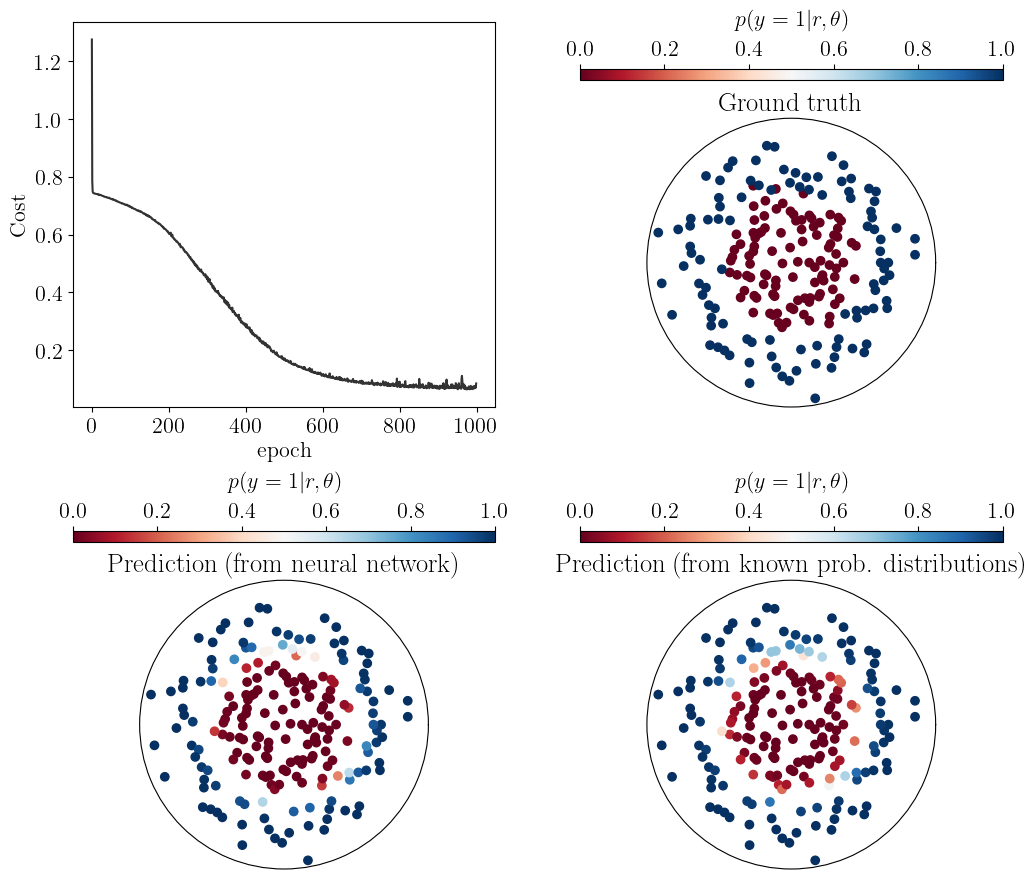

In [13]:
# Plot
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}


plt.rc('text', usetex=True)
plt.rc('font', **font)


fig = plt.figure( figsize=(12, 11) )

#---

ax_cost = fig.add_subplot(2, 2, 1)

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
#ax_cost.set_yscale('log')

#---

ax_referece = fig.add_subplot(2, 2, 2, projection='polar')

ax_referece.set_xticks([])
ax_referece.set_yticks([])
ax_referece.set_title("Ground truth")

labels_reference_plot = ax_referece.scatter(thetas,
                                            Rs,
                                            c = labels,
                                            cmap=cm.RdBu,
                                            vmin=0.0,
                                            vmax=1.0)

cbar_ref = plt.colorbar(labels_reference_plot,
                        ax=ax_referece,
                        orientation='horizontal',
                        location='top',
                        pad=0.1,
                        aspect=40)

cbar_ref.set_label(r'$p(y = 1 | r, \theta)$',  labelpad=10)

#---

ax_result = fig.add_subplot(2, 2, 3, projection='polar')

ax_result.set_xticks([])
ax_result.set_yticks([])
ax_result.set_title("Prediction (from neural network)")

labels_predicted_plot = ax_result.scatter(thetas,
                                            Rs,
                                            c = pred_labels,
                                            cmap=cm.RdBu,
                                            vmin=0.0,
                                            vmax=1.0)

cbar_res = plt.colorbar(labels_predicted_plot,
                    ax=ax_result,
                    orientation='horizontal',
                    location='top',
                    pad=0.1,
                    aspect=40)

cbar_res.set_label(r'$p(y = 1 | r, \theta)$',  labelpad=10)

#---

def gauss_func(x, mu, sigma):
    return np.exp( - (x-mu)**2 /(2*sigma**2)) / \
           np.sqrt(2*np.pi*sigma**2)

pR1 = gauss_func(Rs, R1, noise)
pR2 = gauss_func(Rs, R2, noise)
p_class_R1 = pR1/(pR1 + pR2)


ax_from_probs = fig.add_subplot(2, 2, 4, projection='polar')

ax_from_probs.set_xticks([])
ax_from_probs.set_yticks([])
ax_from_probs.set_title("Prediction (from known prob. distributions)")

labels_from_probs_plot = ax_from_probs.scatter(thetas,
                                            Rs,
                                            c = 1-p_class_R1,
                                            cmap=cm.RdBu,
                                            vmin=0.0,
                                            vmax=1.0)

cbar_res = plt.colorbar(labels_from_probs_plot,
                    ax=ax_from_probs,
                    orientation='horizontal',
                    location='top',
                    pad=0.1,
                    aspect=40)

cbar_res.set_label(r'$p(y = 1 | r, \theta)$',  labelpad=10)

#---
plt.show()

## Example 5: Multilabel classification

### 5.1 Basic example of multilabel classification 

First, we use the library in a simple multilabel classification problem in the $x,y$ plane. Four normally distributed spots with different radial variance and centered to partially overlap between each other are classified attending to their $x,y$ coordinates.   

Next, similarly as it occured in the binary classification example we compare the results with theoretical predictions from the probabilities. Given the probability density functions $r_1, r_2, r_3, r_4$ the relative *height* indicates the chance of classifying in one or other distribution. The probability of a radius $r$ to belong to the class $n$  is then $p_n(r | x, y,) = \frac{r_n(r)}{\sum_{i=1}^N r_i(x,y)}$. We show the probability of correctly classifying the data from the theoretical distribution and compare it to the predictions from the neural network.

In [14]:
n_vals = 200

def create_spot(X0, Y0, sigma_r, n_vals):

    # Generate random angles and radii
    thetas = np.random.uniform(0, 2 * np.pi, n_vals)
    #radii = np.sqrt(np.random.uniform(0, radius**2, n_vals))
    radii = np.random.randn(n_vals)*sigma_r
    
    X = X0 + radii * np.cos(thetas)
    Y = Y0 + radii * np.sin(thetas)

    X = X.reshape(1, n_vals)
    Y = Y.reshape(1, n_vals)

    XY = np.vstack((X,Y))
    return XY

S1_r0 = [-1.75, 0]
S2_r0 = [1.75, 0]
S3_r0 = [0, 1.75]
S4_r0 = [0, -1.75]
S1_sigma_r = 1
S2_sigma_r = 1.25
S3_sigma_r = 1
S4_sigma_r = 1.5
Spot1 =  create_spot(S1_r0[0], S1_r0[1], S1_sigma_r, n_vals)
Spot2 =  create_spot(S2_r0[0], S2_r0[1], S2_sigma_r, n_vals)
Spot3 =  create_spot(S3_r0[0], S3_r0[1], S3_sigma_r, n_vals)
Spot4 =  create_spot(S4_r0[0], S4_r0[1], S4_sigma_r, n_vals)

XY_spots = np.hstack((Spot1,Spot2,Spot3, Spot4))
Y_labels = np.hstack( (np.zeros(n_vals),
                       np.ones(n_vals),
                       np.ones(n_vals)*2,
                       np.ones(n_vals)*3) )

Y_labels= np.int32(Y_labels)


In [15]:
n_inputs = 2
topology = [2, 4, 10, 4]
activation_funcs = ['relu',
                    'relu',
                    'relu',
                    'softmax']

ryc = IAcobus(n_inputs,
                topology,
                activation_funcs,
                cost_func='cross-entropy')


one_hot_Y_labels =  ryc.one_hot_encoding(Y_labels, 4)


cost = ryc.train(XY_spots,
                 one_hot_Y_labels,
                 num_epochs=1000,
                 batch_size=50,
                 learning_rate=1e-3,
                 verbose=True)


pred_spots = ryc.forward(XY_spots)
pred_spots_max_prob = np.argmax(pred_spots, axis=0) # determine the class with maximum probablity

Cost: 0.37286;   Epoch: 990/1000: 100%|██████████| 1000/1000 [00:23<00:00, 41.85it/s]


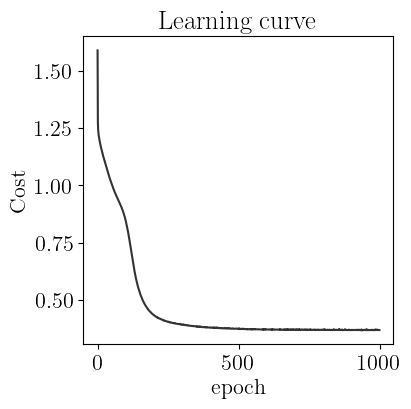

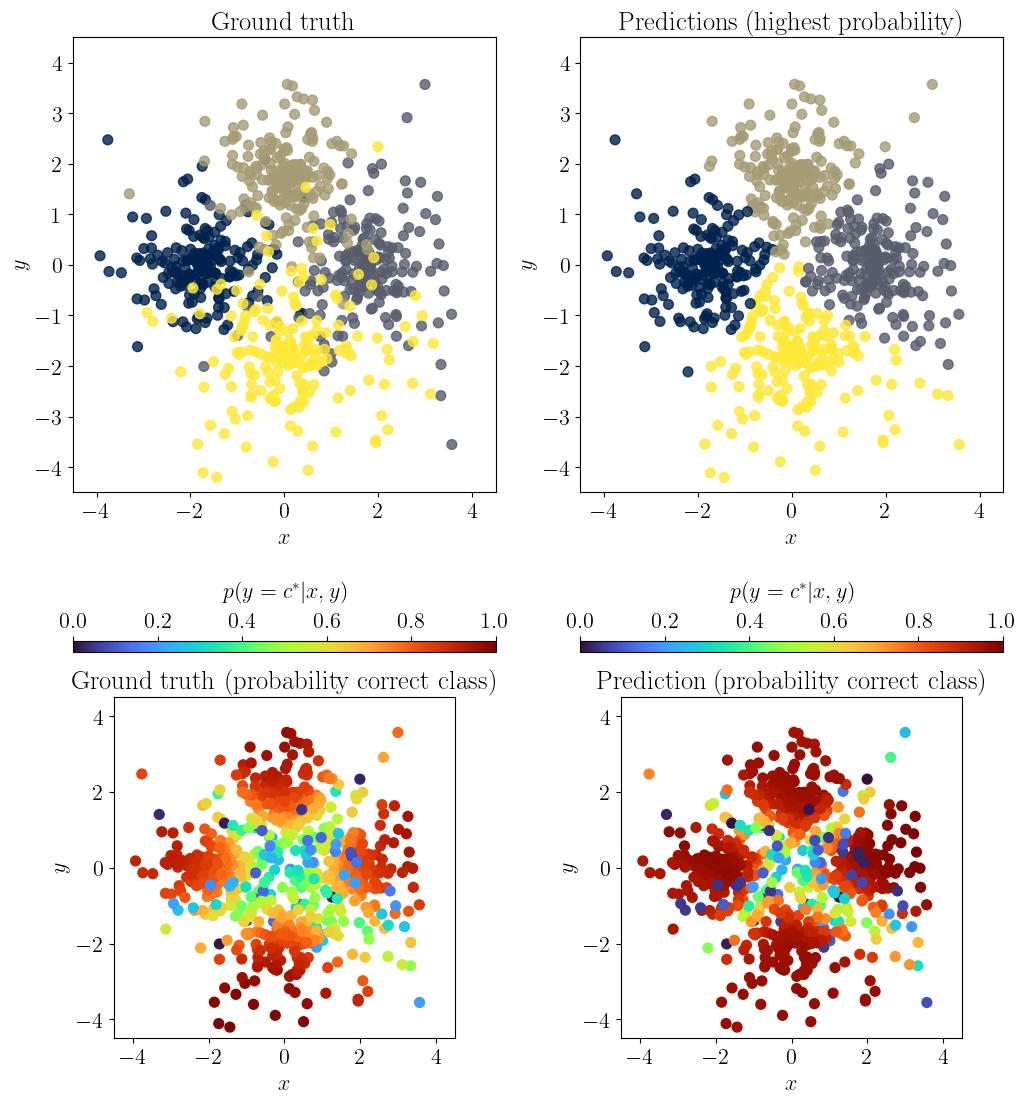

In [16]:
# Plots
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)


fig = plt.figure( figsize=(4, 4) )
ax_cost = fig.add_subplot(1, 1, 1)

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_title(r"Learning curve")

# ---

fig, axes = plt.subplots(2, 2, figsize=(12, 13))
ax_reference_spots = axes[0,0]
ax_pred_spots = axes[0,1]
ax_ground_truth_prob_spots =axes[1,0]
ax_nn_prob_spots = axes[1,1]


ax_reference_spots.set_xlim([-4.5,4.5])
ax_reference_spots.set_ylim([-4.5,4.5])
ax_reference_spots.set_ylabel(r"$y$")
ax_reference_spots.set_xlabel(r"$x$")
ax_reference_spots.set_title(r"Ground truth")

labels_from_ref_plot = ax_reference_spots.scatter(XY_spots[0,:],
                                                 XY_spots[1,:],
                                                 c = Y_labels,
                                                 alpha = 0.8,
                                                 s = 50,
                                                 cmap=cm.cividis,
                                                 vmin=0.0,
                                                 vmax=3.0)

# ---
ax_pred_spots.set_xlim([-4.5,4.5])
ax_pred_spots.set_ylim([-4.5,4.5])
ax_pred_spots.set_ylabel(r"$y$")
ax_pred_spots.set_xlabel(r"$x$")
ax_pred_spots.set_title(r"Predictions (highest probability)")

labels_from_probs_plot = ax_pred_spots.scatter(XY_spots[0,:],
                                              XY_spots[1,:],
                                              c = pred_spots_max_prob,
                                              alpha = 0.8,
                                              s = 50,
                                              cmap=cm.cividis,        
                                              vmin=0.0,
                                              vmax=3.0)


# Probability analysis
def probability_xy(x, y, x0, y0, sigma_r):
        dx = x-x0
        dy = y-y0
        r = np.sqrt(dx**2 + dy**2)
        p = np.exp( - (r-0)**2 /(2*sigma_r**2)) / \
                np.sqrt(2*np.pi*sigma_r**2)

        return p


ground_probs = np.zeros((4, 4*n_vals))
ground_probs[0,:] = probability_xy(XY_spots[0,:], XY_spots[1,:], S1_r0[0], S1_r0[1], S1_sigma_r)
ground_probs[1,:] = probability_xy(XY_spots[0,:], XY_spots[1,:], S2_r0[0], S2_r0[1], S2_sigma_r)
ground_probs[2,:] = probability_xy(XY_spots[0,:], XY_spots[1,:], S3_r0[0], S3_r0[1], S3_sigma_r)
ground_probs[3,:] = probability_xy(XY_spots[0,:], XY_spots[1,:], S4_r0[0], S4_r0[1], S4_sigma_r)
ground_probs = ground_probs/np.sum(ground_probs, axis=0)
prob_correct = np.max(ground_probs *  one_hot_Y_labels, axis=0)


ax_ground_truth_prob_spots.set_xlim([-4.5,4.5])
ax_ground_truth_prob_spots.set_ylim([-4.5,4.5])
ax_ground_truth_prob_spots.set_ylabel(r"$y$")
ax_ground_truth_prob_spots.set_xlabel(r"$x$")
ax_ground_truth_prob_spots.set_title(r"Ground truth (probability correct class)")

labels_ground_probs_analysis_plot = ax_ground_truth_prob_spots.scatter(XY_spots[0,:],
                                                                        XY_spots[1,:],
                                                                        c = prob_correct,
                                                                        s = 50,
                                                                        cmap=cm.turbo,        
                                                                        vmin=0.0,
                                                                        vmax=1.0)

cbar_res_ground_truth_probs_spots = plt.colorbar(labels_ground_probs_analysis_plot,
                                                ax=ax_ground_truth_prob_spots,
                                                orientation='horizontal',
                                                location='top',
                                                pad=0.1,
                                                aspect=40)

cbar_res_ground_truth_probs_spots.set_label(r'$p(y = c^* | x, y)$',  labelpad=10)

# ---
ax_nn_prob_spots.set_xlim([-4.5,4.5])
ax_nn_prob_spots.set_ylim([-4.5,4.5])
ax_nn_prob_spots.set_ylabel(r"$y$")
ax_nn_prob_spots.set_xlabel(r"$x$")
ax_nn_prob_spots.set_title(r"Prediction (probability correct class)")

p_rel = pred_spots/np.sum(pred_spots, axis=0)
prob_correct_nn = np.max(p_rel *  one_hot_Y_labels, axis=0)

labels_nn_probs_analysis_plot = ax_nn_prob_spots.scatter(XY_spots[0,:],
                                                        XY_spots[1,:],
                                                        c = prob_correct_nn,
                                                        s = 50,
                                                        cmap=cm.turbo,        
                                                        vmin=0.0,
                                                        vmax=1.0)

cbar_res_probs_spots = plt.colorbar(labels_nn_probs_analysis_plot,
                                        ax=ax_nn_prob_spots,
                                        orientation='horizontal',
                                        location='top',
                                        pad=0.1,
                                        aspect=40)

cbar_res_probs_spots.set_label(r'$p(y = c^* | x, y)$',  labelpad=10)



ax_ground_truth_prob_spots.set_aspect('equal')
ax_nn_prob_spots.set_aspect('equal')
    
plt.show()